## Import Necessary Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
location = pd.read_csv(r"C:\Users\lenovo\Downloads\predictive+maintenance+dataset\ai4i2020.csv")
data = pd.DataFrame(location)
data.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [4]:
data.duplicated().sum()

0

In [5]:
data.shape

(10000, 14)

In [6]:
data['Machine failure'].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

In [7]:
data = data.drop(columns=['UDI', 'Product ID'], errors='ignore')

In [8]:
data.shape

(10000, 12)

### Since we have categorical values in Type column let us encode it using one hot encoding

In [9]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_type = encoder.fit_transform(data[['Type']])
encoded_type_df = pd.DataFrame(encoded_type, columns=encoder.get_feature_names_out(['Type']))
data = data.drop(columns=['Type']).join(encoded_type_df)

### Lets normalize the numerical columns so as to ensure that each feature have equal weight 

In [10]:
scaler = StandardScaler()
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]','Torque [Nm]','Tool wear [min]'] 
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  float64
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  float64
 5   Machine failure          10000 non-null  int64  
 6   TWF                      10000 non-null  int64  
 7   HDF                      10000 non-null  int64  
 8   PWF                      10000 non-null  int64  
 9   OSF                      10000 non-null  int64  
 10  RNF                      10000 non-null  int64  
 11  Type_L                   10000 non-null  float64
 12  Type_M                   10000 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 1015.8 KB


In [12]:
X = data.drop(columns=['Machine failure']) 
y = data['Machine failure']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (8000, 12)
Testing set size: (2000, 12)


In [13]:
rf_model = RandomForestClassifier(random_state=42)

rfe = RFE(estimator=rf_model, n_features_to_select=7)  
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF',
       'HDF', 'PWF', 'OSF'],
      dtype='object')


### Now using these important features we will train our model so that we can simplify the model and reduces noise from irrelevant features.
### This ensures the model focuses on variables that contribute the most to predicting machine failures.

In [14]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

rf_model.fit(X_train_selected, y_train)

y_pred = rf_model.predict(X_test_selected)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

y_proba = rf_model.predict_proba(X_test_selected)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Accuracy: 0.999

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC Score: 0.9844644379490928


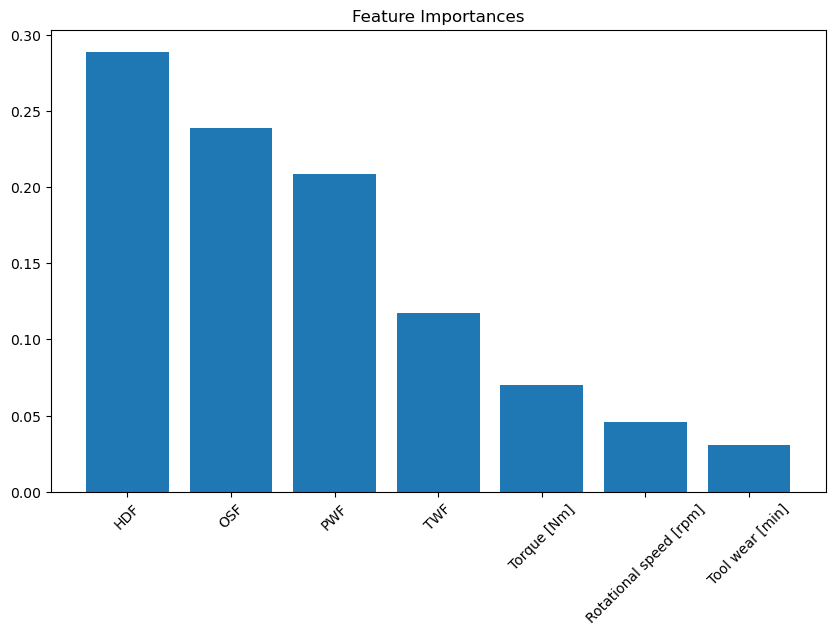

In [15]:
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_features)), feature_importances[sorted_indices])
plt.xticks(range(len(selected_features)), selected_features[sorted_indices], rotation=45)
plt.title("Feature Importances")
plt.show()


### Findings

### Solutions